In [1]:
from BigDFT import Datasets as D, Calculators as C, Inputfiles as I, Logfiles as lf
from BigDFT.Database import Molecules
from futile.Utils import write
import numpy as np
import matplotlib.pyplot as plt
import os, sys
sys.path.insert(0,'../')
from shutil import copyfile
import StatPol as SP, Routines as R

basepath = os.getcwd()
psp_nlcc_aw_path = basepath+'/psp_nlcc_aw'
psp_nlcc_ss_path = basepath+'/psp_nlcc_ss'

/home/marco/Data/RICERCA/DFT AND MANY BODY/LR MOLECULES/Statical polarizability/Analysis/Calculations


## Computation of the statical polarizability for a single study (of the nsp type)

Discuss the workflow to compute the statical polarizability of a specific study defined by the molecule type, the xc and the psp. 

We define the molecule type, build the appropriate folder and move there

In [2]:
os.chdir(basepath)
molecule = 'CO'

if not os.path.isdir('Data'): os.mkdir('Data')
os.chdir('Data')
if not os.path.isdir(molecule): os.mkdir(molecule)
os.chdir(molecule)
sys.path.insert(1,'../../../')

print os.getcwd()

/home/marco/Data/RICERCA/DFT AND MANY BODY/LR MOLECULES/Statical polarizability/Analysis/Calculations/Data/CO


Set some global parameters

In [3]:
wf_convergence = 1.0e-6
hgrids = 0.3
rmult_fine = 9.0

In [4]:
posinp=Molecules.Molecule(molecule)
#posinp

In [5]:
code=C.SystemCalculator(omp=2,mpi_run='mpirun -np 4',skip=True)

Initialize a Calculator with OMP_NUM_THREADS=2 and command mpirun -np 4 /home/marco/Applications/BigDFT/binaries/v1.8.3/install/bin/bigdft


In [6]:
# Test of a single run to check if the way to attribute xc and psp works correctly. The xc_pbe_nlcc_aw and 
# xc_pbe_nlcc_ss methods have to be slightly modified to add the ''-test' in the folder name.

study = ('pbe', 'hgh_k')
path=study[0]+'-'+study[1]+'-'+'test'
if not os.path.isdir(path): os.mkdir(path)
path

inp = I.Inputfile()
inp.set_hgrid(hgrids)
inp.set_rmult(coarse=3.0,fine=rmult_fine)
R.set_xc[study](inp,molecule)
inp.set_wavefunction_convergence(wf_convergence)
print inp

code.run(input=inp,posinp=posinp,run_dir=path,name='test')

{'dft': {'rmult': [3.0, 9.0], 'gnrm_cv': 1e-06, 'hgrids': 0.3, 'ixc': '-406'}, 'psppar.C': {'Pseudopotential XC': 11}, 'psppar.O': {'Pseudopotential XC': 11}}
Creating the yaml input file "pbe0-hgh_k-test/test.yaml"
Run directory pbe0-hgh_k-test
Executing command:  mpirun -np 4 /home/marco/Applications/BigDFT/binaries/v1.8.3/install/bin/bigdft -n test -s Yes


<BigDFT.Logfiles.Logfile instance at 0x7f4b19c64908>

Execute the complete convergence procedure.

Set the study type build the folder associated to the study and define the path variable

In [19]:
study = ('lda_pw', 'hgh_k')
path=study[0]+'-'+study[1]
if not os.path.isdir(path): os.mkdir(path)
path

'lda_pw-hgh_k'

Build a dictionary to collect the results of the analysis

In [20]:
results = {}

Perform a convergence study for the gs. Use the value of the total energy (or the value of the gs dipole) to set the dimension of the box

In [21]:
reload(SP)
rtol=10*wf_convergence #relative tolerance for the gs convergence using the total energy as control quantity

inp = I.Inputfile()
inp.set_hgrid(hgrids)
R.set_xc[study](inp,molecule)
inp.set_wavefunction_convergence(wf_convergence)
print inp

rmult_coarse = [1.0*i for i in range(3,12)]
data = []
code.update_global_options(verbose=False)
for r in rmult_coarse:
    gs_study = D.Dataset(label=molecule+'_GS',run_dir=path,posinp=posinp)
    gs_study.set_postprocessing_function(SP.get_energy)
    #gs_study.set_postprocessing_function(SP.get_dipole)
    inp.set_rmult(coarse=r,fine=rmult_fine)
    idd={'rmult':r}
    gs_study.append_run(id=idd,runner=code,input=inp)
    data.append(gs_study)
    
results['gs_conv'] = SP.seek_convergence(rt=rtol,label='rmult',values=rmult_coarse,data=data)
results

{'dft': {'ixc': '-001012', 'hgrids': 0.3, 'gnrm_cv': 1e-06}, 'psppar.C': {'Pseudopotential XC': 1}, 'psppar.O': {'Pseudopotential XC': 1}}
Perform the run with rmult 3.0
Perform the run with rmult 4.0
Convergence for rmult 3.0 failed
Perform the run with rmult 5.0
Convergence for rmult 4.0 failed
Perform the run with rmult 6.0
Convergence achieved for rmult 5.0


{'gs_conv': {'converged': True,
  'converged_value': 5.0,
  'label': 'rmult',
  'results': {3.0: -21.625148150463765,
   4.0: -21.66358122369752,
   5.0: -21.666325122605194,
   6.0: -21.66652425463323,
   7.0: None,
   8.0: None,
   9.0: None,
   10.0: None,
   11.0: None},
  'values': [3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]}}

It emerges that the convergence performed with the energy is less demanding that the one done with the dipole!

Convergence flow for the calculation of alpha: take the rmult of the gs convergence. Perform the field convergence with this value of rmult and finally perform the rmult convergence for alpha using the converged value of the field

In [22]:
rtol=1e-2 #relative tolerance for the alpha convergence

gs_conv = results['gs_conv']['converged_value']
inp.set_rmult(coarse=gs_conv,fine=rmult_fine)
print inp

results['field_conv']=SP.perform_field_convergence(rt=rtol,run_dir=path,input=inp,\
                      runner=code,posinp=posinp,ppf=SP.eval_alpha)
print ''

f=results['field_conv']['converged_value']

rmult_list=SP.build_rmult_list([gs_conv,rmult_fine])
results['rmult_conv']=SP.perform_rmult_convergence(rt=rtol,run_dir=path,intensity=f,\
                      rmult=rmult_list,input=inp,runner=code,posinp=posinp,ppf=SP.eval_alpha)

{'dft': {'ixc': '-001012', 'rmult': [5.0, 9.0], 'hgrids': 0.3, 'gnrm_cv': 1e-06}, 'psppar.C': {'Pseudopotential XC': 1}, 'psppar.O': {'Pseudopotential XC': 1}}
Perform the run with field_int 0.01
Perform the run with field_int 0.005
Convergence achieved for field_int 0.01

Perform the run with rmult 5.0
Perform the run with rmult 6.0
Convergence for rmult 5.0 failed
Perform the run with rmult 7.0
Convergence achieved for rmult 6.0


In [23]:
r_conv = results['rmult_conv']['converged_value']
alpha_final = results['rmult_conv']['results'][r_conv]
print alpha_final
print SP.eval_alpha_avg(alpha_final)

[[ 1.2627460e+01 -1.3880000e-05 -5.6710000e-05]
 [-1.3880000e-05  1.2627460e+01 -5.6710000e-05]
 [-3.7000000e-05 -3.7000000e-05  1.5852766e+01]]
13.702562


In [11]:
results

{'field_conv': {'converged': True,
  'converged_value': 0.01,
  'label': 'field_int',
  'results': {0.0005: None,
   0.001: None,
   0.005: matrix([[ 1.2449322e+01, -8.6670000e-05, -2.5460000e-05],
           [-8.6670000e-05,  1.2449322e+01, -2.5460000e-05],
           [-3.3000000e-05, -3.3000000e-05,  1.5586878e+01]]),
   0.01: matrix([[ 1.2466885e+01, -7.9495000e-05, -3.5490000e-05],
           [-7.9495000e-05,  1.2466885e+01, -3.5490000e-05],
           [-5.7500000e-05, -5.7500000e-05,  1.5607136e+01]])},
  'values': [0.01, 0.005, 0.001, 0.0005]},
 'gs_conv': {'converged': True,
  'converged_value': 5.0,
  'label': 'rmult',
  'results': {3.0: -21.625148150463765,
   4.0: -21.66358122369752,
   5.0: -21.666325122605194,
   6.0: -21.66652425463323,
   7.0: None,
   8.0: None,
   9.0: None,
   10.0: None,
   11.0: None},
  'values': [3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]},
 'rmult_conv': {'converged': True,
  'converged_value': 6.0,
  'label': 'rmult',
  'results': {5.0: matri

In [12]:
r_values = results['rmult_conv']['values']
r_values.sort()
r_plot = []
alpha_values = []

for r in r_values:
    a = results['rmult_conv']['results'][r]
    if not (a is None):
        r_plot.append(r)
        alpha_values.append(SP.eval_alpha_avg(a))

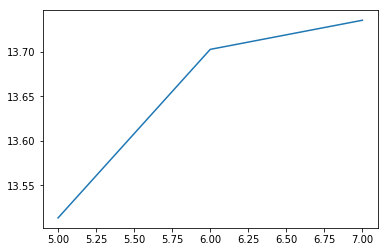

In [13]:
plt.plot(r_plot,alpha_values)

This workflow is translated into the single method nsp_workflow and stored in the Routines.py